# LIF神经元

In [5]:
# import snntorch as snn
from spikingjelly.activation_based import surrogate
# from snntorch import functional as SF
# from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from abc import ABCMeta, abstractmethod

from torchvision import datasets, transforms
from tqdm.notebook import tqdm  # tqdm 进度条显示
# import tqdm # 在pycharm里面调用这个
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

脉冲神经元基类

In [6]:
class BaseNode(nn.Module):
    def __init__(self, v_threshold=1.0, v_reset=0.0, surrogate_function=surrogate.Sigmoid(), detach_reset=False, monitor_state=False):
        '''
        * :ref:`API in English <BaseNode.__init__-en>`

        .. _BaseNode.__init__-cn:

        :param v_threshold: 神经元的阈值电压

        :param v_reset: 神经元的重置电压。如果不为 ``None``，当神经元释放脉冲后，电压会被重置为 ``v_reset``；
            如果设置为 ``None``，则电压会被减去 ``v_threshold``

        :param surrogate_function: 反向传播时用来计算脉冲函数梯度的替代函数

        :param detach_reset: 是否将reset过程的计算图分离

        :param monitor_state: 是否设置监视器来保存神经元的电压和释放的脉冲。
            若为 ``True``，则 ``self.monitor`` 是一个字典，键包括 ``h``, ``v`` ``s``，分别记录充电后的电压、释放脉冲后的电压、释放的脉冲。
            对应的值是一个链表。为了节省显存（内存），列表中存入的是原始变量转换为 ``numpy`` 数组后的值。
            还需要注意，``self.reset()`` 函数会清空这些链表

        可微分SNN神经元的基类神经元。
       '''
        super().__init__()
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.detach_reset = detach_reset
        self.surrogate_function = surrogate_function
        self.monitor = monitor_state
        self.reset()
        
    @abstractmethod  # 用于定义抽象方法，必须被子类实现。
    def neuronal_charge(self, dv: torch.Tensor):
        '''
        定义神经元的充电差分方程。子类必须实现这个函数。
        '''
        raise NotImplementedError
        
    def neuronal_fire(self):
        '''
        生成脉冲
        根据当前神经元的电压、阈值，计算输出脉冲。
        '''
        if self.monitor:
            if self.monitor['h'].__len__() == 0:
                # 补充在0时刻的电压
                if self.v_reset is None:
                    self.monitor['h'].append(self.v.data.cpu().numpy().copy() * 0)
                else:
                    self.monitor['h'].append(self.v.data.cpu().numpy().copy() * self.v_reset)
            else:
                self.monitor['h'].append(self.v.data.cpu().numpy().copy())

        self.spike = self.surrogate_function(self.v - self.v_threshold)
        #surrogate function默认是Sigmoid，\alpha为1。 在前向传播时，使用神经元的输出			
        #离散的0和1，我们的网络仍然是SNN；而反向传播时，使用梯度替代函数的梯度来代替脉冲函数的梯度。
        if self.monitor:
            self.monitor['s'].append(self.spike.data.cpu().numpy().copy())

    def neuronal_reset(self):
        '''
        根据当前神经元释放的脉冲，对膜电位进行重置。
        '''
        if self.detach_reset:
            spike = self.spike.detach()
        else:
            spike = self.spike

        if self.v_reset is None: #不重置减去阈值
            # 脉冲为1的减去阈值，为0的不变
            self.v = self.v - spike * self.v_threshold
        else: #重置恢复为v_reset值
            # 脉冲为0的电压值保持不变，为1的电压值变为重置电压，一般为0.
            self.v = (1 - spike) * self.v + spike * self.v_reset

        if self.monitor:
            self.monitor['v'].append(self.v.data.cpu().numpy().copy())

    def forward(self, dv: torch.Tensor): #前向forward
        '''
        :param dv: 输入到神经元的电压增量
        :return: 神经元的输出脉冲
        '''
        self.neuronal_charge(dv)
        self.neuronal_fire()
        self.neuronal_reset()
        return self.spike

    def set_monitor(self, monitor_state=True):
        '''
        设置开启或关闭monitor。
        '''
        if monitor_state:
            self.monitor = {'h': [], 'v': [], 's': []}
        else:
            self.monitor = False
 
    def extra_repr(self):
        '''
        设置模块的额外表示信息。
        '''
        return f'v_threshold={self.v_threshold}, v_reset={self.v_reset}, detach_reset={self.detach_reset}'
        
    def reset(self):
        '''
        重置神经元为初始状态，也就是将电压设置为 ``v_reset``。
        如果子类的神经元还含有其他状态变量，需要在此函数中将这些状态变量全部重置。
        一般在下一个epoch训练前进行
        '''
        if self.v_reset is None:
            self.v = 0.0
        else:
            self.v = self.v_reset

        self.spike = None

        if self.monitor:
            self.monitor = {'h': [], 'v': [], 's': []}


LIF神经元

In [7]:
class LIFNode(BaseNode):
    """
    BaseNode类的子类，需要实现其中的一个抽象方法
    """
    def __init__(self, tau=100.0, v_threshold=1.0, v_reset=0.0, surrogate_function=surrogate.Sigmoid(), detach_reset=False,
                 monitor_state=False):
        super().__init__(v_threshold, v_reset, surrogate_function, detach_reset, monitor_state)
        self.tau = tau

    def extra_repr(self):
        return f'v_threshold={self.v_threshold}, v_reset={self.v_reset}, tau={self.tau}'

    def neuronal_charge(self, dv: torch.Tensor):
        """
        LIF神经元动态微分方程对应的差分方程
        """
        if self.v_reset is None: #这里的dv就是上一层的输出，公式中的X(t)
            self.v += (dv - self.v) / self.tau
        else:
            self.v += (dv - (self.v - self.v_reset)) / self.tau

无状态编码的基类

In [8]:
class StatelessEncoder(nn.Module):
    def __init__(self):
        """
        无状态编码器的基类。无状态编码器 ``encoder = StatelessEncoder()``，直接调用 ``encoder(x)`` 即可将 ``x`` 编码为 ``spike``。
        """
        super().__init__()

    @abstractmethod
    def forward(self, x: torch.Tensor):
        """
        :param x: 输入数据
        :type x: torch.Tensor
        :return: ``spike``, shape 与 ``x.shape`` 相同
        :rtype: torch.Tensor
        """
        raise NotImplementedError

泊松编码

In [9]:
class PoissonEncoder(StatelessEncoder):
    """
    StatelessEncoder的子类
    """
    def __init__(self):
        """
        无状态的泊松编码器。输出脉冲的发放概率与输入 ``x`` 相同。
        .. warning::
            必须确保 ``0 <= x <= 1``。
        """
        super().__init__()

    def forward(self, x: torch.Tensor):
        out_spike = torch.rand_like(x).le(x)
        # torch.rand_like(x)生成与x相同shape的介于[0, 1)之间的随机数， 这个随机数小于等于x中对应位置的元素，则发放脉冲
        return out_spike

网络重置函数

In [10]:
def reset_net(net: nn.Module):
    '''
    :param net: 任何属于 ``nn.Module`` 子类的网络
    :return: None
    将网络的状态重置。做法是遍历网络中的所有 ``Module``，若含有 ``reset()`` 函数，则调用。
    reset()函数即是LIFNode类中的方法
    '''
    for m in net.modules():
        if hasattr(m, 'reset'):
            m.reset()

#### 训练测试  
在LIF（Leaky Integrate-and-Fire）神经元模型中，τ（通常表示为$τ_m$）是膜电位的时间常数。这个时间常数反映了神经元膜电位变化的速度，从而影响了神经元的动态特性。更具体地说，$τ_m$ 决定了膜电位的上升和下降的速度。较大的时间常数会导致膜电位的变化速度变慢，使得神经元对输入的响应更加缓慢，而较小的时间常数则会导致膜电位变化更快，神经元对输入的响应更加敏感。由于$τ_m$的存在，神经元不能立即对输入做出反应，而是需要一定的时间，这符合了生物神经元的生理特性。因此，τ参数在LIF神经元中扮演着关键的角色，影响着神经元在接收到输入信号时的膜电位变化速度，进而影响其动态行为。

In [11]:
tau = 1 # tau的取值可以调整，这里我们测试了100,10,1 发现在100,10的情况下，网络的过拟合现象非常严重。
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 14 * 14, bias=False), #这里不加bias应该是偏置在SNN中不好表示
    LIFNode(tau=tau),
    nn.Linear(14 * 14, 10, bias=False),
    LIFNode(tau=tau))

In [12]:
bs = 512 # 暂且设置为128

# 使用Mnist数据集
train_set = datasets.MNIST("../data",train=True,download=False, transform=transforms.ToTensor(),)
test_set = datasets.MNIST("../data",train=False,download=False, transform=transforms.ToTensor(),)

train_loader = DataLoader(dataset=train_set, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=bs, shuffle=False,drop_last = True)

train_epoch = 20
# T指的是仿真时长，T越大，实验时间越大。所需显存数量与仿真时长 T 线性相关，更长的 T 相当于使用更小的仿真步长，
# 训练更为“精细”，但训练效果不一定更好，因此 T 太大，SNN在时间上展开后就会变成一个非常深的网络，梯度的传递容易衰减或爆炸。
# 由于我们使用了泊松编码器，因此需要较大的 T。 
T = 5 # 个人理解就是一个batch中对数据进行脉冲编码的次数，每一次的结果都相加，理解为脉冲序列的相加
encoder = PoissonEncoder()
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_function = F.mse_loss
net =net.to(device)
train_accs = []
train_loss = []
test_accs = []
test_loss = []

In [13]:
for epoch in range(train_epoch):
    _ = net.train()
    sums = 0
    accuracys = 0
    los = 0
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()
        
        img = img.to(device)
        label = label.to(device)
        sums += label.shape[0]
        label_one_hot = F.one_hot(label, 10).float()
        for t in range(T):
            if t == 0:
                out_spikes_counter = net(encoder(img).float())
            else:
                out_spikes_counter += net(encoder(img).float())
        out_spikes_counter_frequency = out_spikes_counter / T
        loss = loss_function(out_spikes_counter_frequency, label_one_hot,reduction='sum')
        loss.backward()
        optimizer.step()
        reset_net(net)
        # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        los += loss.item()
        accuracys += (out_spikes_counter_frequency.max(1)[1] == label.to(device)).float().sum().item()

    temp = round(accuracys / sums * 100,2)
    temp2 = round(los / sums,4)
    print(f"第{epoch+1}次迭代的整体准确率为{temp}%, 平均损失为{temp2}")
    train_accs.append(temp)
    train_loss.append(temp2)
    
    # 查看网络在测试集上的准确率与损失
    _ = net.eval()
    with torch.no_grad():
        sums = 0
        accuracys = 0
        los = 0
        for img, label in tqdm(test_loader):
            img = img.to(device)
            label = label.to(device)
            sums += label.shape[0]
            label_one_hot = F.one_hot(label, 10).float()
            for t in range(T):
                if t == 0:
                    out_spikes_counter = net(encoder(img).float())
                else:
                    out_spikes_counter += net(encoder(img).float())
            out_spikes_counter_frequency = out_spikes_counter / T
            loss = loss_function(out_spikes_counter_frequency, label_one_hot,reduction='sum')

            los += loss.item()
            accuracys += (out_spikes_counter_frequency.max(1)[1] == label.to(device)).float().sum().item()
        temp = round(accuracys / sums * 100,2)
        temp2 = round(los / sums,4)
        print(f"网络在测试上的整体准确率为{temp}%, 平均损失为{temp2}")
        test_accs.append(temp)
        test_loss.append(temp2)

  0%|          | 0/118 [00:00<?, ?it/s]

第1次迭代的整体准确率为85.0%, 平均损失为0.2518


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为92.68%, 平均损失为0.1663


  0%|          | 0/118 [00:00<?, ?it/s]

第2次迭代的整体准确率为94.11%, 平均损失为0.1064


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为93.42%, 平均损失为0.1113


  0%|          | 0/118 [00:00<?, ?it/s]

第3次迭代的整体准确率为95.3%, 平均损失为0.0852


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为95.13%, 平均损失为0.0829


  0%|          | 0/118 [00:00<?, ?it/s]

第4次迭代的整体准确率为95.93%, 平均损失为0.0746


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为95.56%, 平均损失为0.0758


  0%|          | 0/118 [00:00<?, ?it/s]

第5次迭代的整体准确率为96.63%, 平均损失为0.0625


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为95.79%, 平均损失为0.071


  0%|          | 0/118 [00:00<?, ?it/s]

第6次迭代的整体准确率为96.95%, 平均损失为0.0576


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为95.99%, 平均损失为0.0669


  0%|          | 0/118 [00:00<?, ?it/s]

第7次迭代的整体准确率为97.36%, 平均损失为0.0509


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为96.12%, 平均损失为0.0659


  0%|          | 0/118 [00:00<?, ?it/s]

第8次迭代的整体准确率为97.52%, 平均损失为0.0482


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为96.44%, 平均损失为0.0615


  0%|          | 0/118 [00:00<?, ?it/s]

第9次迭代的整体准确率为97.72%, 平均损失为0.0454


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为96.68%, 平均损失为0.0618


  0%|          | 0/118 [00:00<?, ?it/s]

第10次迭代的整体准确率为97.72%, 平均损失为0.0443


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为96.58%, 平均损失为0.0593


  0%|          | 0/118 [00:00<?, ?it/s]

第11次迭代的整体准确率为97.99%, 平均损失为0.0408


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为96.54%, 平均损失为0.0629


  0%|          | 0/118 [00:00<?, ?it/s]

第12次迭代的整体准确率为98.15%, 平均损失为0.038


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.02%, 平均损失为0.0538


  0%|          | 0/118 [00:00<?, ?it/s]

第13次迭代的整体准确率为98.31%, 平均损失为0.0358


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.17%, 平均损失为0.0511


  0%|          | 0/118 [00:00<?, ?it/s]

第14次迭代的整体准确率为98.39%, 平均损失为0.0342


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为96.76%, 平均损失为0.0594


  0%|          | 0/118 [00:00<?, ?it/s]

第15次迭代的整体准确率为98.38%, 平均损失为0.0341


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.26%, 平均损失为0.0514


  0%|          | 0/118 [00:00<?, ?it/s]

第16次迭代的整体准确率为98.51%, 平均损失为0.0321


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.0%, 平均损失为0.052


  0%|          | 0/118 [00:00<?, ?it/s]

第17次迭代的整体准确率为98.57%, 平均损失为0.0315


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.28%, 平均损失为0.0494


  0%|          | 0/118 [00:00<?, ?it/s]

第18次迭代的整体准确率为98.65%, 平均损失为0.03


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.34%, 平均损失为0.0489


  0%|          | 0/118 [00:00<?, ?it/s]

第19次迭代的整体准确率为98.72%, 平均损失为0.0292


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.23%, 平均损失为0.0513


  0%|          | 0/118 [00:00<?, ?it/s]

第20次迭代的整体准确率为98.64%, 平均损失为0.0292


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为97.14%, 平均损失为0.0517


[博客学习1](https://blog.csdn.net/cyy0789/article/details/121351527?spm=1001.2014.3001.5502)  
[博客学习2](https://blog.csdn.net/cyy0789/article/details/121432756?spm=1001.2014.3001.5502)  
[博客学习3](https://blog.csdn.net/cyy0789/article/details/127440891?spm=1001.2014.3001.5502)

In [25]:
import snntorch as snn
import torch
from torchvision import datasets, transforms
from snntorch import utils
from torch.utils.data import DataLoader
from snntorch import spikegen

# 绘图三件套
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML  

In [16]:
# Training Parameters
batch_size=128
data_path='../data'
num_classes = 10  # MNIST has 10 output classes
# Torch Variables
dtype = torch.float # tensor中的数据全部存储为torch.float型
# Define a transform 图像变换，通过定义好一个transform对象实现 , 转为tensor，并归一化至[0-1]
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))]) 

In [19]:
mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
# 在我们实际开始训练网络之前，不需要太大的数据集，通过utils中的data_subset函数将MNIST数据集数目从60000减少到6000
subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


In [20]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
# Temporal Dynamics
num_steps = 10
# create vector filled with 0.5
raw_vector = torch.ones(num_steps) * 0.5
# pass each sample through a Bernoulli trial     使每个样本通过伯努利试验
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Raw vector: {raw_vector}")
print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Raw vector: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
Converted vector: tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])
The output is spiking 80.00% of the time.


In [21]:
num_steps = 100
# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5
# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 52.00% of the time.


In [23]:
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


In [27]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


The corresponding target is: 7


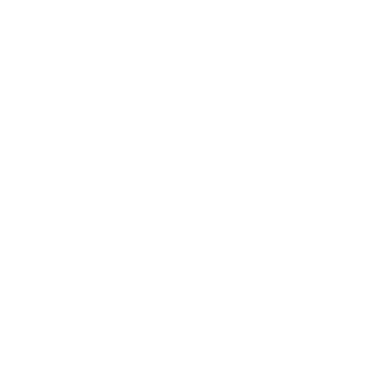

In [31]:
# `spikeplot.animator` makes it super simple to animate 2-D data.<br>
# Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe
# 经过测试，在jupyter运行可以产生视频
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# 这一步需要自己下载ffmpeg ，参考链接：https://blog.csdn.net/baidu_37366055/article/details/139833145
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\ALiang\Desktop\ffmpeg-7.0.2-essentials_build\bin\ffmpeg.exe'
HTML(anim.to_html5_video())
anim.save("spike_mnist_test.mp4")
print(f"The corresponding target is: {targets_it[0]}")

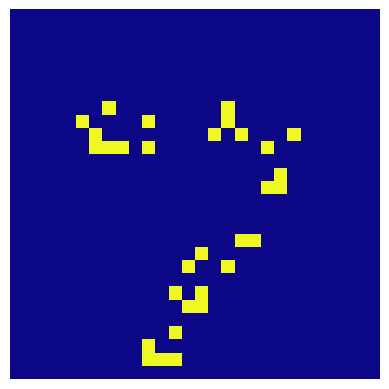

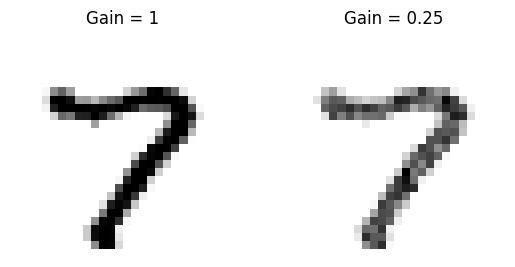

In [32]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)
spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

plt.figure(facecolor="w")
plt.subplot(1,2,1)
# 这里用的是上面的数据
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

torch.Size([100, 784])


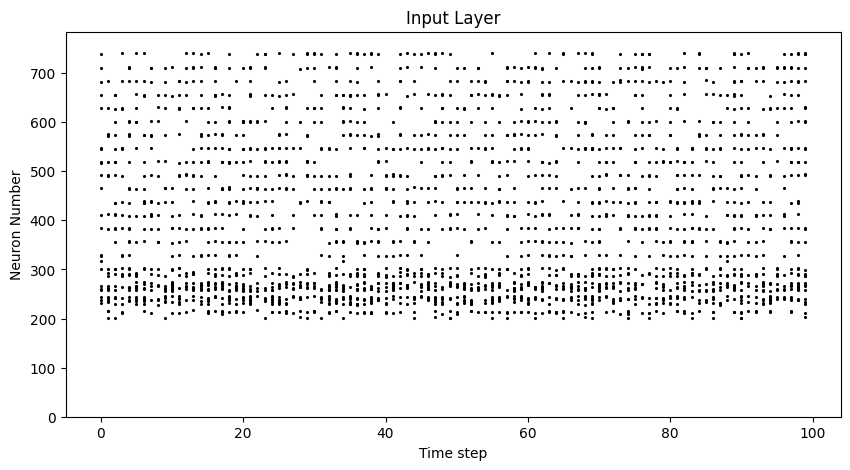

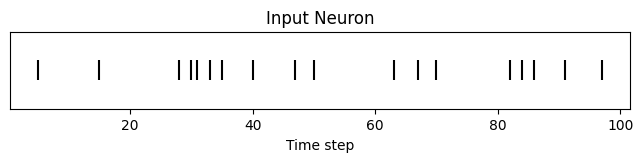

In [42]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))
print(spike_data_sample2.shape)
# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")
plt.ylim(0, 784)  # 设置显示所有行
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

idx = 210  # index into 210th neuron
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=200, c="black", marker="|")
plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

延迟编码

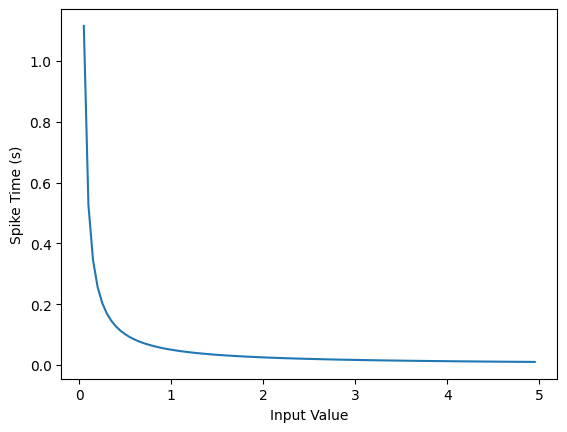

In [43]:
def convert_to_time(data, tau=5, threshold=0.01):
    spike_time = tau * torch.log(data / (data - threshold))
    return spike_time 


raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

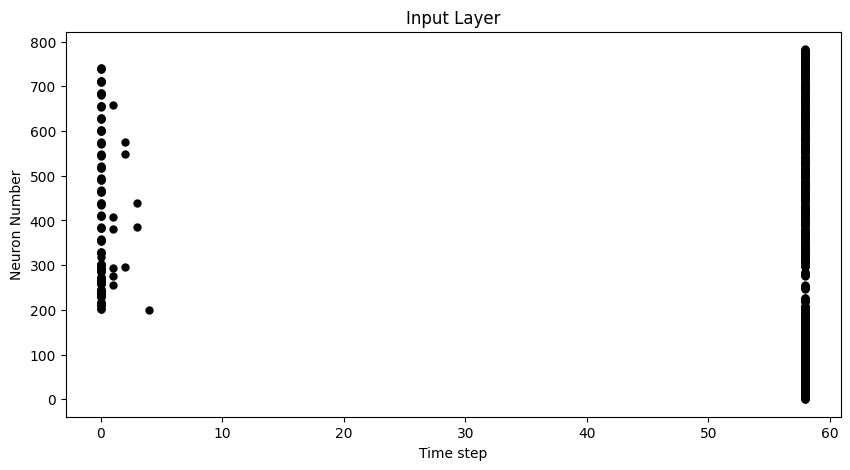

In [44]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

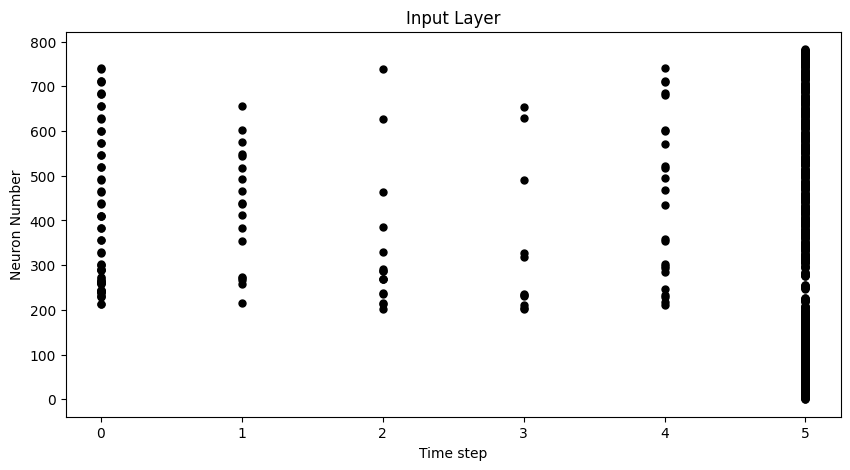

In [45]:
# 设置 linear=True
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

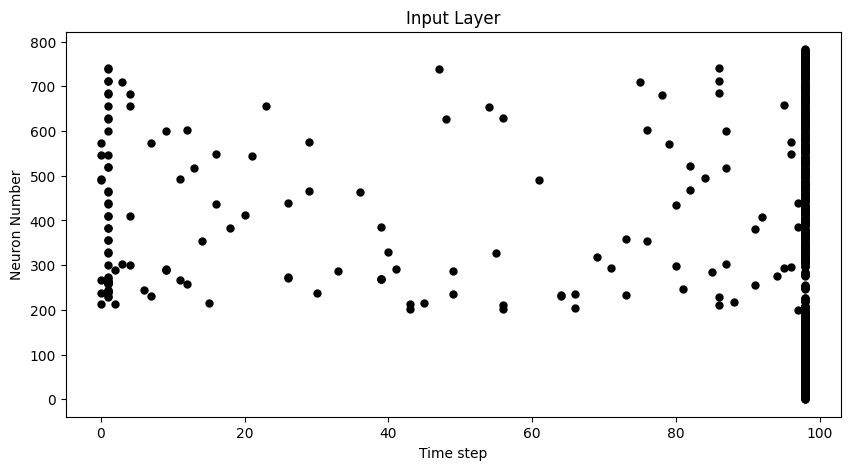

In [46]:
# 设置normalize=True, linear=True
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

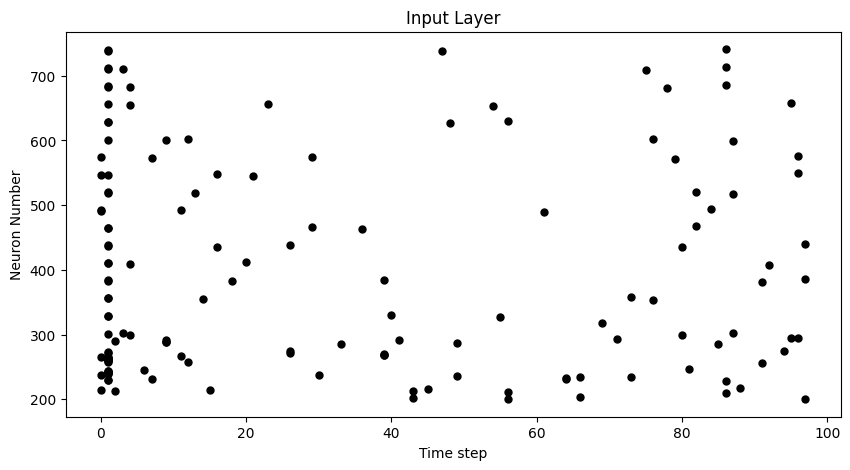

In [47]:
# 设置 clip=True, normalize=True, linear=True ，作用应该是裁剪掉在最后一个时间步发放脉冲的神经元，全部置为0
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, 
                              clip=True, normalize=True, linear=True)
# spike_data = spikegen.rate(data_it, num_steps=num_steps)  # 原始的是这个数据生成函数，速率编码

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

torch.Size([100, 28, 28])
The corresponding target is: 7


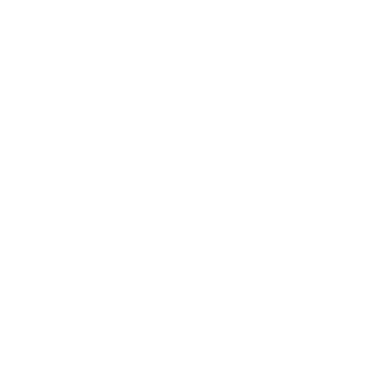

In [49]:
# 这里的 spike_data 是已经和刚开的spike_data相比，相差很大，是延迟编码
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# 这一步需要自己下载ffmpeg ，参考链接：https://blog.csdn.net/baidu_37366055/article/details/139833145
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\ALiang\Desktop\ffmpeg-7.0.2-essentials_build\bin\ffmpeg.exe'
HTML(anim.to_html5_video())
anim.save("spike_mnist_test2.mp4")
print(f"The corresponding target is: {targets_it[0]}")

增量编码

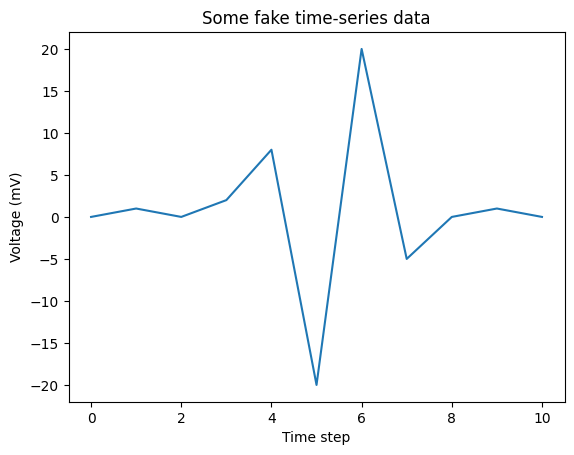

In [53]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)
plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])


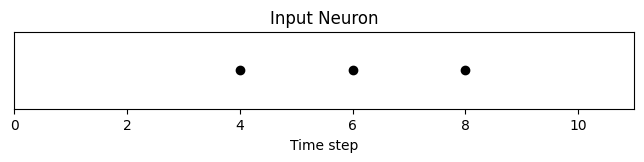

In [57]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)
print(spike_data)
# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)
# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")
plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

tensor([  0.,   1.,   0.,   2.,   8., -20.,  20.,  -5.,   0.,   1.,   0.])
tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


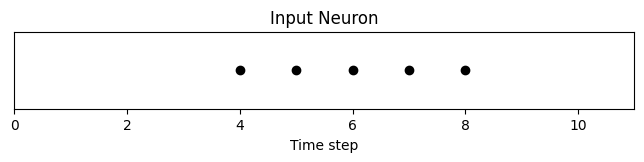

In [67]:
# Convert data
print(data)
spike_data = spikegen.delta(data, threshold=4, off_spike=True)
print(spike_data)
# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)
# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")
plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

生成MP4视频文件的函数

In [75]:
def mp4_generate(data, targets_it, ffmpeg = r'C:\Users\ALiang\Desktop\ffmpeg-7.0.2-essentials_build\bin\ffmpeg.exe',
                 save_path = "spike_mnist_test3.mp4"):
    fig, ax = plt.subplots()
    anim = splt.animator(data, fig, ax)
    # 这一步需要自己下载ffmpeg ，参考链接：https://blog.csdn.net/baidu_37366055/article/details/139833145
    plt.rcParams['animation.ffmpeg_path'] = ffmpeg
    HTML(anim.to_html5_video())
    anim.save(save_path)
    print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 7


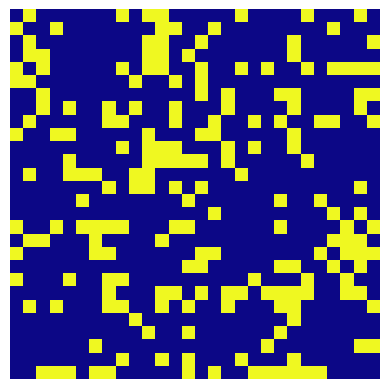

In [73]:
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)
mp4_generate(spike_rand, targets_it)
# fig, ax = plt.subplots()
# anim = splt.animator(spike_rand, fig, ax)
# # 这一步需要自己下载ffmpeg ，参考链接：https://blog.csdn.net/baidu_37366055/article/details/139833145
# plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\ALiang\Desktop\ffmpeg-7.0.2-essentials_build\bin\ffmpeg.exe'
# HTML(anim.to_html5_video())
# anim.save("spike_mnist_test3.mp4")
# print(f"The corresponding target is: {targets_it[0]}")

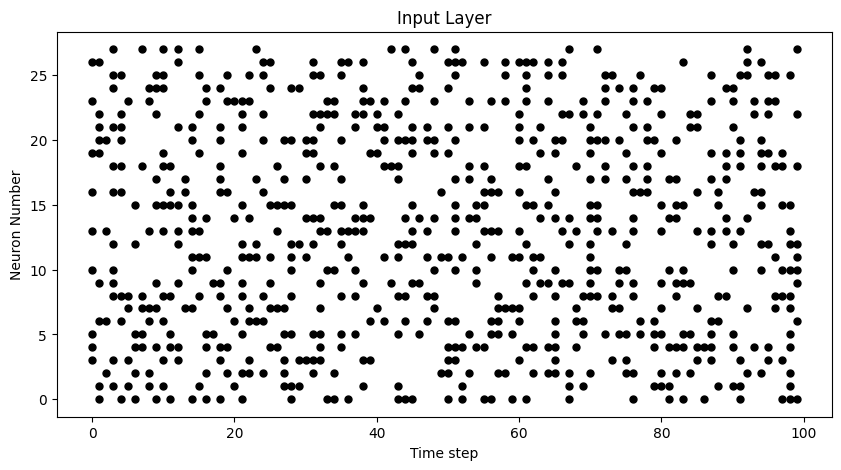

In [70]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# --------------------------------------------------------------------------------

### ANN to SNN

In [77]:
# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [86]:
import torch
from spikingjelly.clock_driven import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt
import numpy as np
from spikingjelly.activation_based import ann2snn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### 1.查看IF神经元并与ReLU函数进行对比

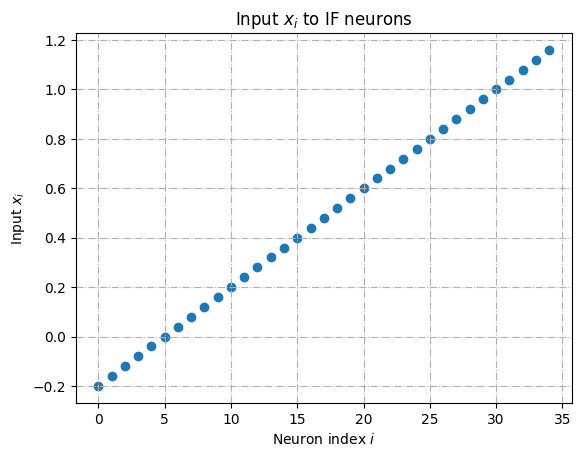

In [79]:
plt.rcParams['figure.dpi'] = 100
if_node = neuron.IFNode(v_reset=None)
T = 128
x = torch.arange(-0.2, 1.2, 0.04)  # 长度35，当x= 1时，对应的位置序号为30，当x=0时，对应的位置为5
plt.scatter(torch.arange(x.shape[0]), x)
plt.title('Input $x_{i}$ to IF neurons')
plt.xlabel('Neuron index $i$')
plt.ylabel('Input $x_{i}$')
plt.grid(linestyle='-.')
plt.show()

In [80]:
class IFNode(BaseNode):
    def __init__(self, v_threshold=1.0, v_reset=0.0, surrogate_function=surrogate.Sigmoid(), detach_reset=False, monitor_state=False):
        '''
        Integrate-and-Fire 神经元模型，可以看作理想积分器，无输入时电压保持恒定，不会像LIF神经元那样衰减。
        '''
        super().__init__(v_threshold, v_reset, surrogate_function, detach_reset, monitor_state)
    def neuronal_charge(self, dv: torch.Tensor):
        self.v += dv #这里的dv就是上一层的输出，公式中的X(t)

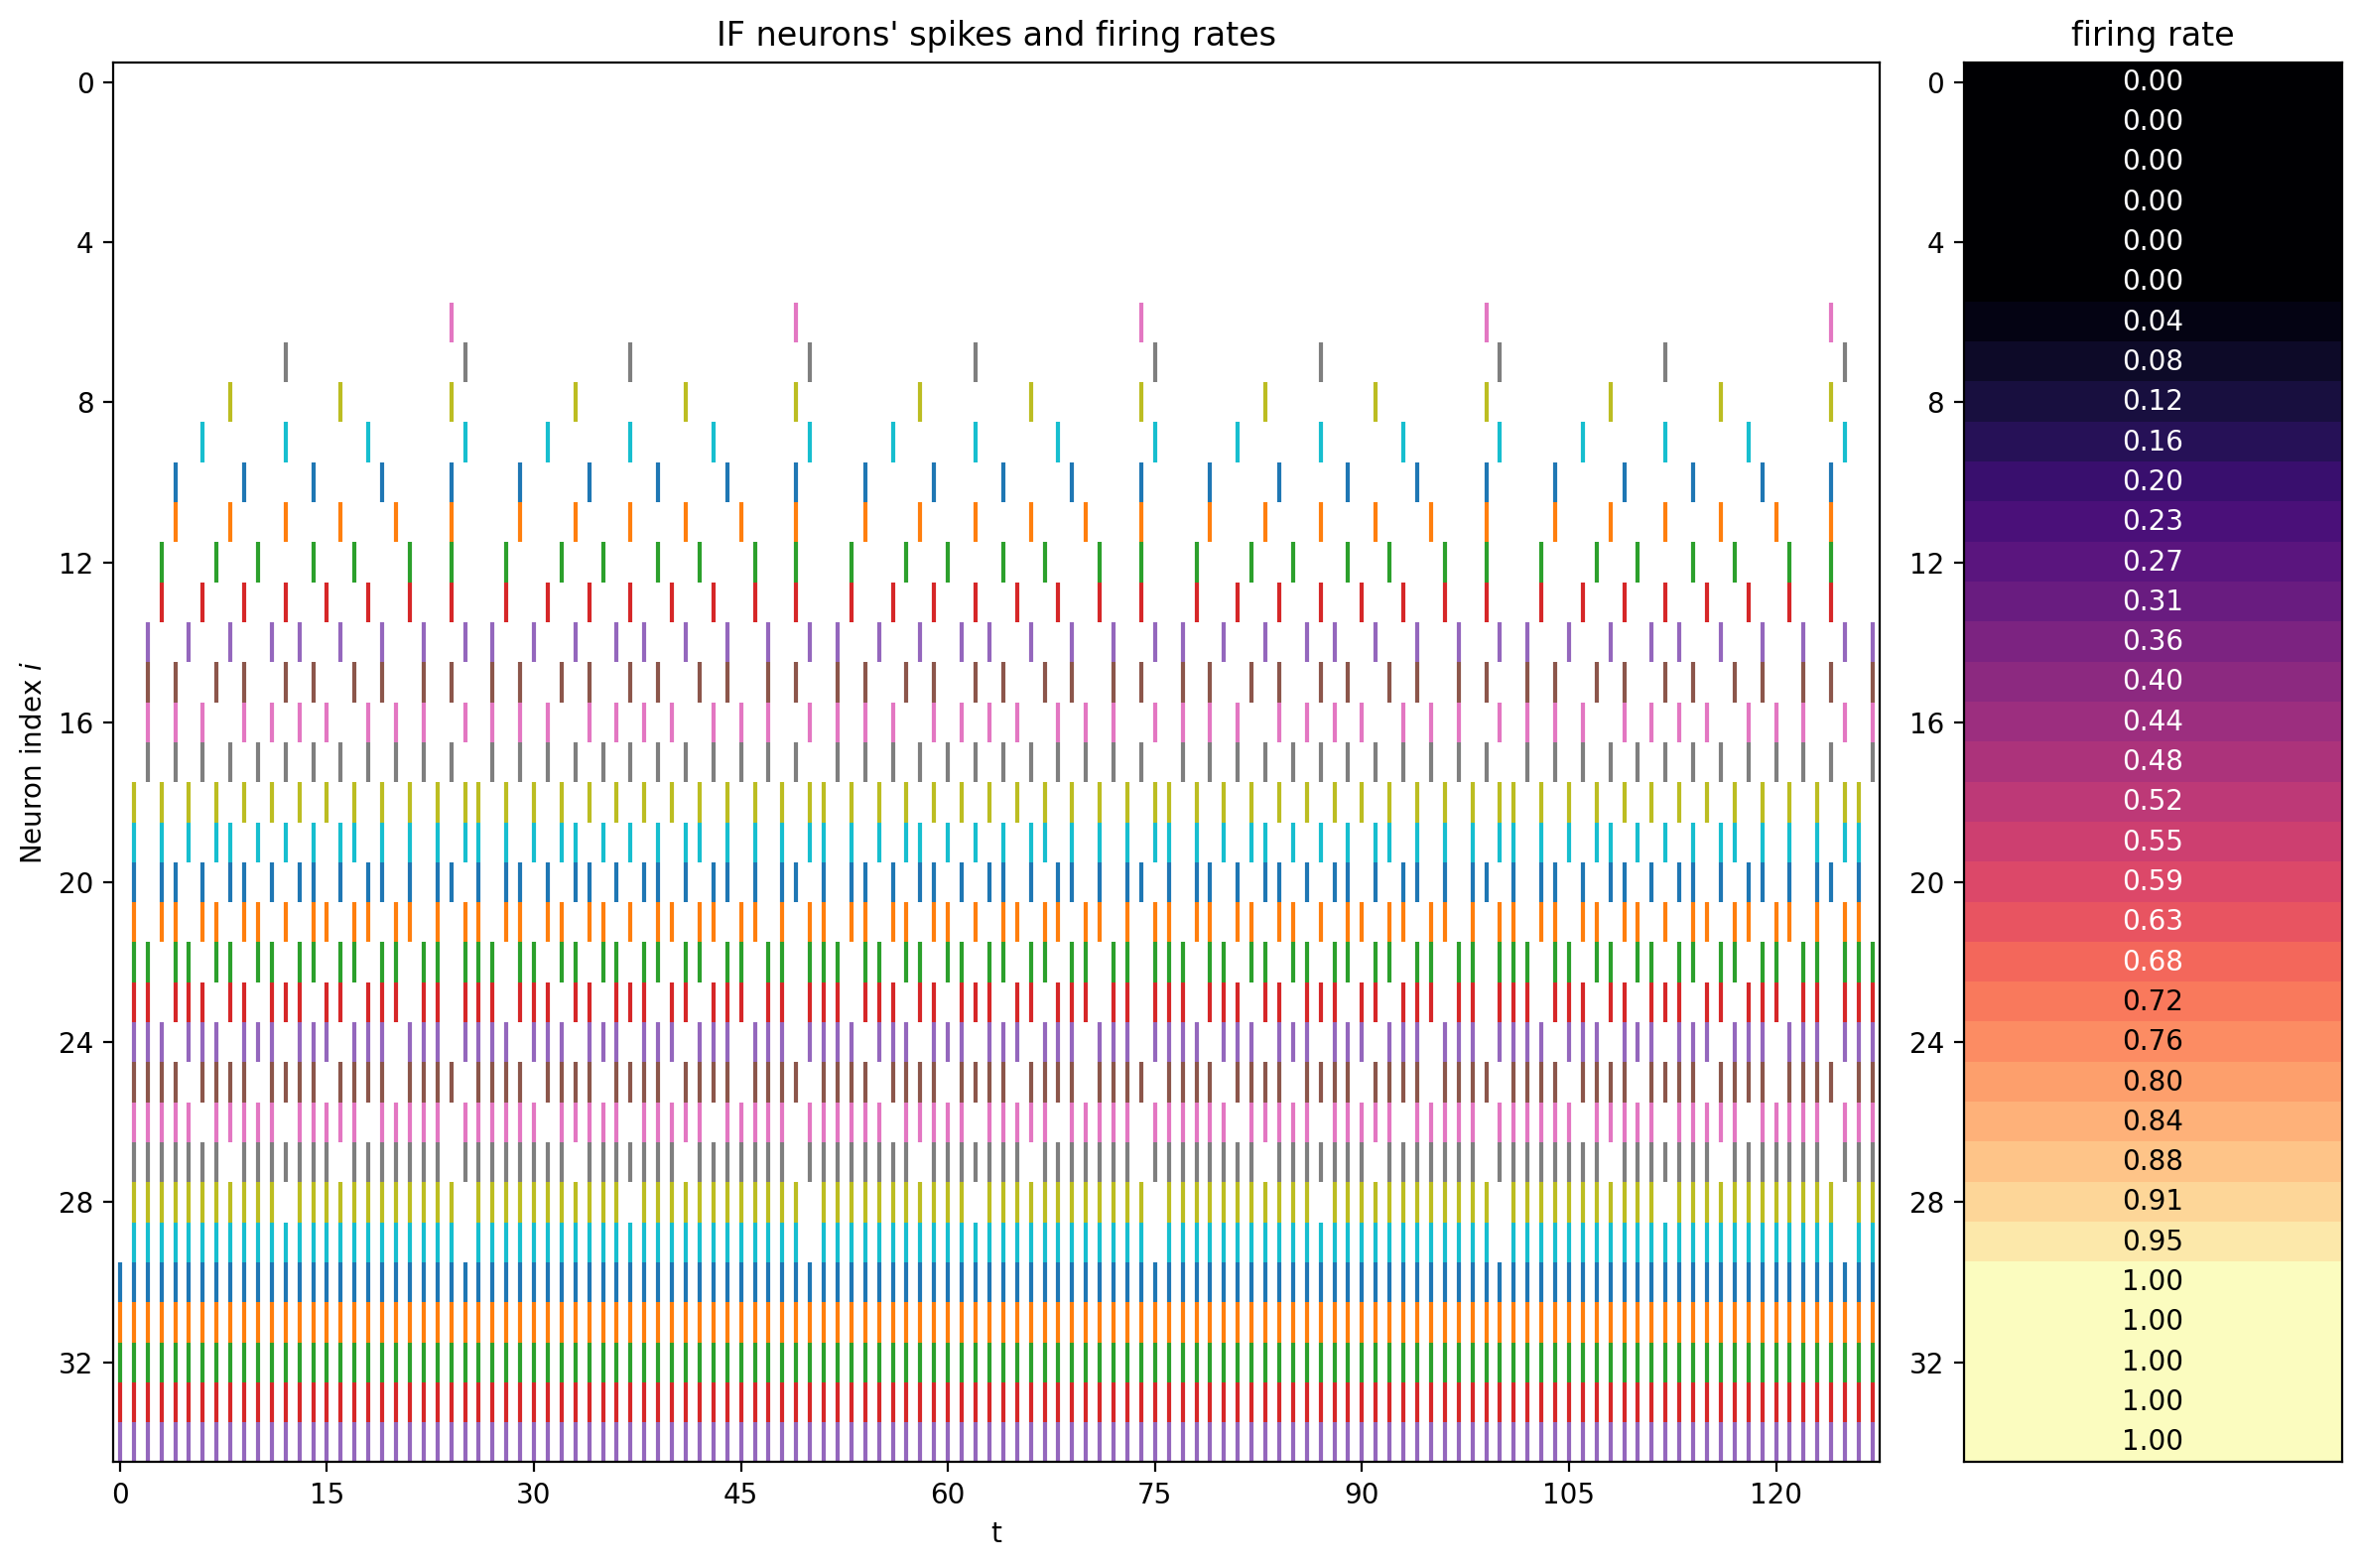

In [81]:
s_list = []
for t in range(T):
    s_list.append(if_node(x).unsqueeze(0))

out_spikes = np.asarray(torch.cat(s_list))
s = visualizing.plot_1d_spikes(out_spikes, 'IF neurons\' spikes and firing rates', 't', 'Neuron index $i$')
plt.show()

In [82]:
out_spikes.shape  # 步数是128个，输入的x个数是35，我们在步数这个维度对脉冲数求平均，即为平均脉冲发放频率
np.mean(out_spikes, axis=0)
5/128,10/128,16/128,21/128,25/128,31/128

(0.0390625, 0.078125, 0.125, 0.1640625, 0.1953125, 0.2421875)

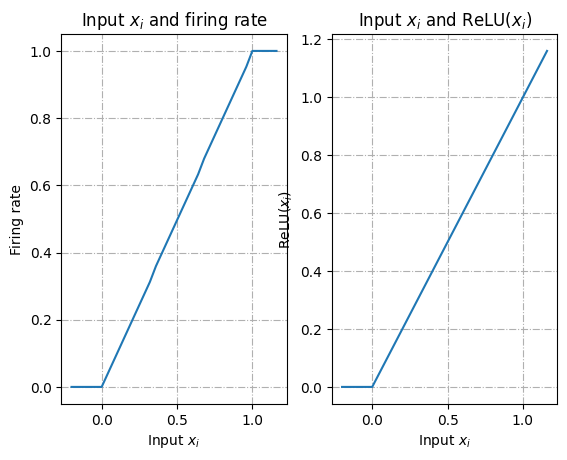

In [83]:
plt.subplot(1, 2, 1)
firing_rate = np.mean(out_spikes, axis=0)
plt.plot(x, firing_rate)
plt.title('Input $x_{i}$ and firing rate')
plt.xlabel('Input $x_{i}$')
plt.ylabel('Firing rate')
plt.grid(linestyle='-.')

plt.subplot(1, 2, 2)
plt.plot(x, x.relu())
plt.title('Input $x_{i}$ and ReLU($x_{i}$)')
plt.xlabel('Input $x_{i}$')
plt.ylabel('ReLU($x_{i}$)')
plt.grid(linestyle='-.')
plt.show()

##### 2.ANN转SNN

In [84]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(32, 10),
            nn.ReLU()
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [87]:
lr = 1e-2
ann = ANN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=lr, weight_decay=5e-4)

In [89]:
bs = 512 # 暂且设置为128

# 使用Mnist数据集
train_set = datasets.MNIST("../data",train=True,download=False, transform=transforms.ToTensor(),)
test_set = datasets.MNIST("../data",train=False,download=False, transform=transforms.ToTensor(),)

train_loader = DataLoader(dataset=train_set, batch_size=bs, shuffle=True,  drop_last = True)
test_loader = DataLoader( dataset=test_set,  batch_size=bs, shuffle=False, drop_last = True)

train_epoch = 5
best_acc = 0
train_accs = []
train_loss = []
test_accs = []
test_loss = []

In [90]:
for epoch in range(train_epoch):
    ss = ann.train()
    sums = 0
    accuracys = 0
    los = 0
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        sums += label.shape[0]
        # 预测值
        pred = ann(img)
        pred_classes = torch.max(pred, dim=1)[1]
        # 损失函数
        loss = loss_function(pred, label)
        loss.backward()
        # 优化器
        optimizer.step()
        optimizer.zero_grad()

        # 正确率
        los += loss.item()
        accuracys += (pred_classes == label).float().sum().item()

    temp = round(accuracys / sums * 100,2)
    temp2 = round(los / sums,4)
    print(f"第{epoch+1}次迭代的整体准确率为{temp}%, 平均损失为{temp2}")
    train_accs.append(temp)
    train_loss.append(temp2)
    
    # 查看网络在测试集上的准确率与损失
    ss = ann.eval()
    with torch.no_grad():
        sums = 0
        accuracys = 0
        los = 0
        for img, label in tqdm(test_loader):
            img = img.to(device)
            label = label.to(device)
            sums += label.shape[0]
            # 预测值
            pred = ann(img)
            pred_classes = torch.max(pred, dim=1)[1]

            # 损失函数
            loss = loss_function(pred, label)

            # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
            los += loss.item()
            accuracys += (pred_classes == label).float().sum().item()
        temp = round(accuracys / sums * 100,2)
        temp2 = round(los / sums,4)
        print(f"网络在测试上的整体准确率为{temp}%, 平均损失为{temp2}")
        test_accs.append(temp)
        test_loss.append(temp2)
        
    if best_acc < temp:
        torch.save(ann.state_dict(),'save_models/ann_test.pth' )
        best_acc = temp
        print("update weight")

  0%|          | 0/117 [00:00<?, ?it/s]

第1次迭代的整体准确率为63.6%, 平均损失为0.0022


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为71.27%, 平均损失为0.0017
update weight


  0%|          | 0/117 [00:00<?, ?it/s]

第2次迭代的整体准确率为76.78%, 平均损失为0.0015


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为70.64%, 平均损失为0.0016


  0%|          | 0/117 [00:00<?, ?it/s]

第3次迭代的整体准确率为77.86%, 平均损失为0.0015


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为76.1%, 平均损失为0.0015
update weight


  0%|          | 0/117 [00:00<?, ?it/s]

第4次迭代的整体准确率为77.88%, 平均损失为0.0014


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为77.52%, 平均损失为0.0014
update weight


  0%|          | 0/117 [00:00<?, ?it/s]

第5次迭代的整体准确率为78.09%, 平均损失为0.0014


  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为77.05%, 平均损失为0.0016


In [91]:
ann2 = ANN().to(device)
ann2.load_state_dict(torch.load('save_models/ann_test.pth' ))

C:\Users\ALiang\AppData\Local\Temp\ipykernel_25500\4017093908.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann2.load_state_dict(torch.load('save_models/ann_test.pth' 

<All keys matched successfully>

In [92]:
_ = ann2.eval()
with torch.no_grad():
    sums = 0
    accuracys = 0
    los = 0
    for img, label in tqdm(test_loader):
        img = img.to(device)
        label = label.to(device)
        sums += label.shape[0]
        # 预测值
        pred = ann2(img)
        pred_classes = torch.max(pred, dim=1)[1]

        # 损失函数
        loss = loss_function(pred, label)

        # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        los += loss.item()
        accuracys += (pred_classes == label).float().sum().item()
    temp = round(accuracys / sums * 100,2)
    temp2 = round(los / sums,4)
    print(f"网络在测试上的整体准确率为{temp}%, 平均损失为{temp2}")
    test_accs.append(temp)
    test_loss.append(temp2)

  0%|          | 0/19 [00:00<?, ?it/s]

网络在测试上的整体准确率为77.52%, 平均损失为0.0014


##### 3.网络转换

In [93]:
# 测试转换代码
model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
snn_model = model_converter(ann2)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:11<00:00, 10.29it/s]


In [94]:
T = 50
model = ann2

In [95]:
def val(net, device, data_loader, T=None):
    net.eval().to(device)
    correct = 0.0
    total = 0.0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch, (img, label) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            if T is None:
                out = net(img)
                correct += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            else:
                for m in net.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        out = net(img)
                    else:
                        out += net(img)
                    corrects[t] += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            total += out.shape[0]
    return correct / total if T is None else corrects / total

In [96]:
print('---------------------------------------------')
print('Converting using MaxNorm')
model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_max_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_max_accs[-1]))

print('---------------------------------------------')
print('Converting using RobustNorm')
model_converter = ann2snn.Converter(mode='99.9%', dataloader=train_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_robust_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_robust_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/2 max(activation) as scales...')
model_converter = ann2snn.Converter(mode=1.0 / 2, dataloader=train_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_two_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_two_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/3 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 3, dataloader=train_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_three_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_three_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/4 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 4, dataloader=train_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_four_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_four_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/5 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 5, dataloader=train_loader)
snn_model = model_converter(model)
print('Simulating...')
mode_five_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_five_accs[-1]))

---------------------------------------------
Converting using MaxNorm


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:11<00:00, 10.46it/s]


Simulating...


  0%|          | 0/19 [00:00<?, ?it/s]

SNN accuracy (simulation 50 time-steps): 0.7609
---------------------------------------------
Converting using RobustNorm


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:31<00:00,  3.71it/s]

Simulating...


  0%|          | 0/19 [00:00<?, ?it/s]

SNN accuracy (simulation 50 time-steps): 0.7756
---------------------------------------------
Converting using 1/2 max(activation) as scales...


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:11<00:00, 10.46it/s]

Simulating...


  0%|          | 0/19 [00:00<?, ?it/s]

SNN accuracy (simulation 50 time-steps): 0.7584
---------------------------------------------
Converting using 1/3 max(activation) as scales


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:11<00:00, 10.12it/s]

Simulating...


  0%|          | 0/19 [00:00<?, ?it/s]

SNN accuracy (simulation 50 time-steps): 0.7535
---------------------------------------------
Converting using 1/4 max(activation) as scales


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.71it/s]

Simulating...


  0%|          | 0/19 [00:00<?, ?it/s]

SNN accuracy (simulation 50 time-steps): 0.7441
---------------------------------------------
Converting using 1/5 max(activation) as scales


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.67it/s]

Simulating...


  0%|          | 0/19 [00:00<?, ?it/s]

SNN accuracy (simulation 50 time-steps): 0.7222
